In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier

In [22]:
np.random.seed(42)
n = 40000
a = np.random.uniform(-10, 10, n)
b = np.random.uniform(-10, 10, n)
X = np.random.uniform(-10, 10, n)
y = X**2 + a * X + b

discriminant = a**2 - 4*b

r = (discriminant < 0).astype(int)
# Ensure class balance (20%-40% ones)
ones_ratio = np.mean(r)
target_min, target_max = 0.3, 0.5
if ones_ratio < target_min or ones_ratio > target_max:
    zero_indices = np.where(r == 0)[0]
    one_indices = np.where(r == 1)[0]
    target_ones = int(n * np.random.uniform(target_min, target_max))

    if len(one_indices) > target_ones:
        drop_ones = np.random.choice(one_indices, len(one_indices) - target_ones, replace=False)
        r[drop_ones] = 0
    elif len(one_indices) < target_ones:
        add_ones = np.random.choice(zero_indices, target_ones - len(one_indices), replace=False)
        r[add_ones] = 1

# Combine into DataFrame
df = pd.DataFrame({'a': a, 'b': b, 'y': y, 'r': r})
train, test = train_test_split(df, test_size=0.2, random_state=42)

# Check class balance
print(df['r'].value_counts(normalize=True))

r
0    0.67405
1    0.32595
Name: proportion, dtype: float64


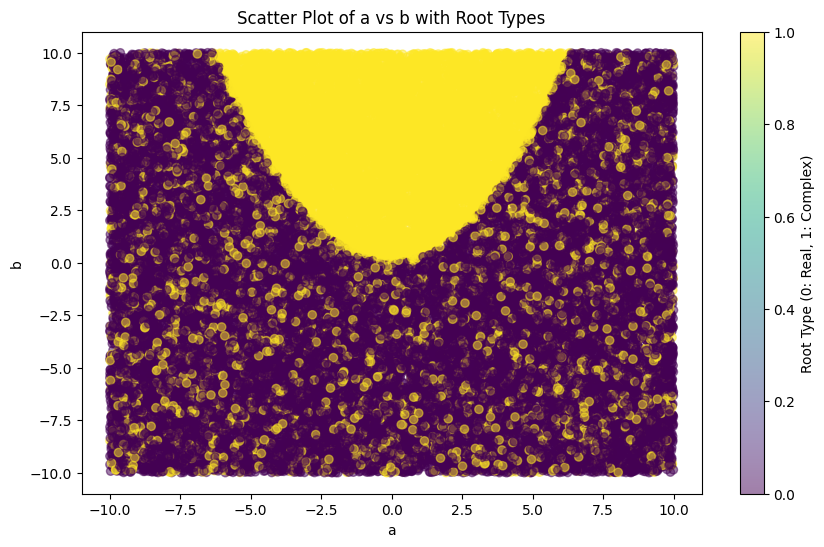

In [4]:
plt.figure(figsize=(10, 6))
plt.scatter(df['a'], df['b'], c=df['r'], cmap='viridis', alpha=0.5)
plt.colorbar(label='Root Type (0: Real, 1: Complex)')
plt.xlabel('a')
plt.ylabel('b')
plt.title('Scatter Plot of a vs b with Root Types')
plt.savefig('scatter_plot.png')
plt.show()

What we want

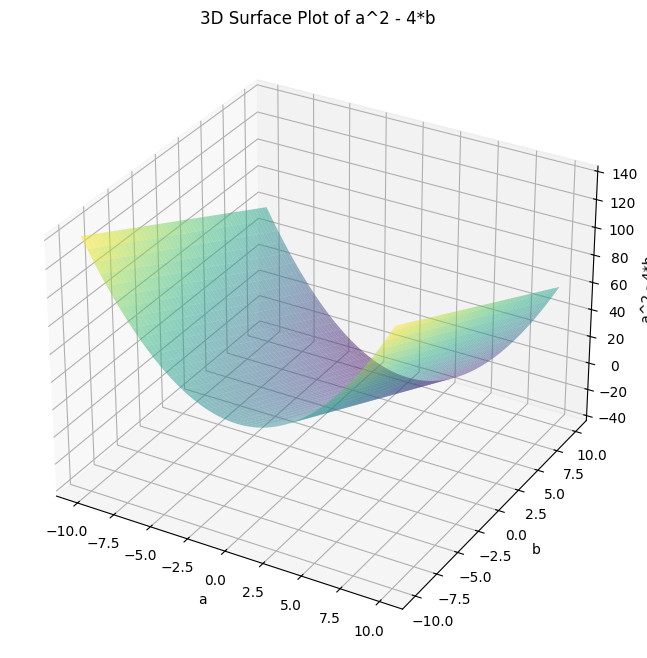

In [5]:
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
a_range = np.linspace(-10, 10, 100)
b_range = np.linspace(-10, 10, 100)
A, B = np.meshgrid(a_range, b_range)
Z = A**2 - 4*B
ax.plot_surface(A, B, Z, cmap='viridis', alpha=0.5)
ax.set_xlabel('a')
ax.set_ylabel('b')
ax.set_zlabel('a^2 - 4*b')
plt.title('3D Surface Plot of a^2 - 4*b')
plt.savefig('3d_surface_plot.png')
plt.show()

Baseline: p = 0.65, r = 0.65, f1 = 0.65

In [23]:
X_train = train[['a', 'b']]
y_train = train['r']
X_test = test[['a', 'b']]
y_test = test['r']
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

svm = SVC(kernel='rbf', random_state=42)
svm.fit(X_train_scaled, y_train)
y_pred = svm.predict(X_test_scaled)
print("Test set classification report:")
print(classification_report(y_test, y_pred))

Test set classification report:
              precision    recall  f1-score   support

           0       0.85      0.98      0.91      5376
           1       0.95      0.64      0.77      2624

    accuracy                           0.87      8000
   macro avg       0.90      0.81      0.84      8000
weighted avg       0.88      0.87      0.86      8000



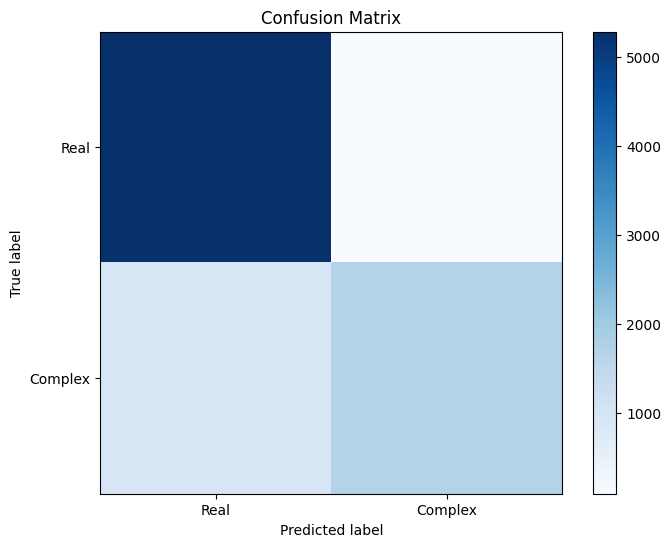

In [13]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
plt.xticks(np.arange(2), ['Real', 'Complex'])
plt.yticks(np.arange(2), ['Real', 'Complex'])
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.savefig('confusion_matrix.png')
plt.show()

/tmp/ipykernel_9342/3528450445.py:77: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed in 3.10.
  ax2.legend([contour_svm.collections[0], contour_true.collections[0], scatter2],


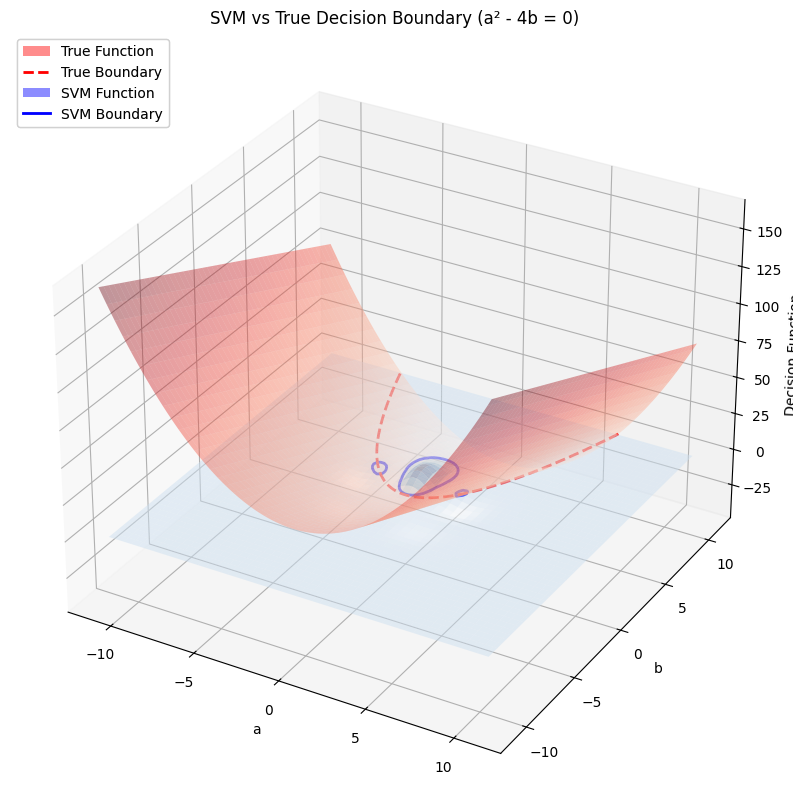

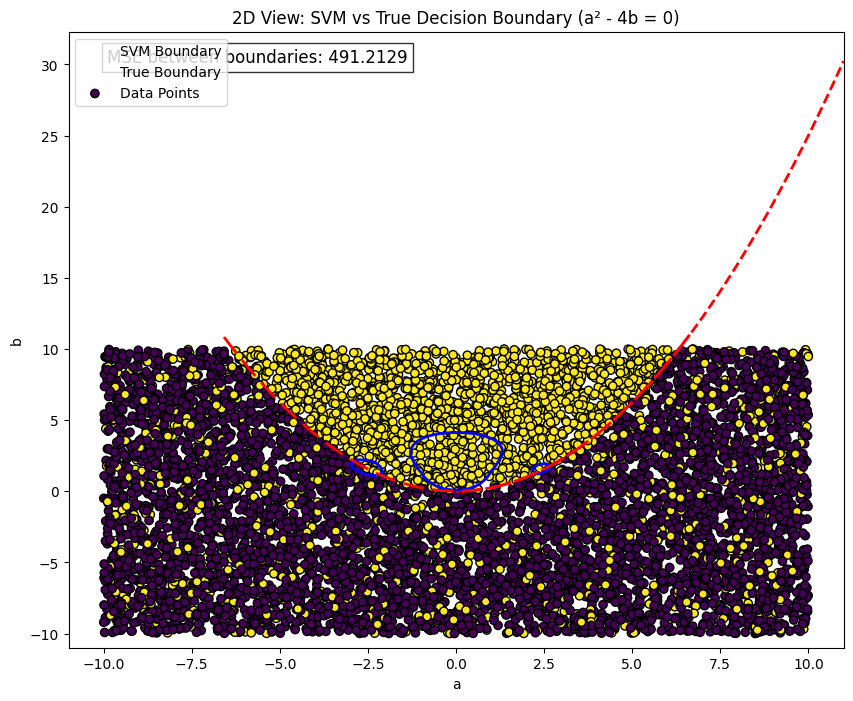

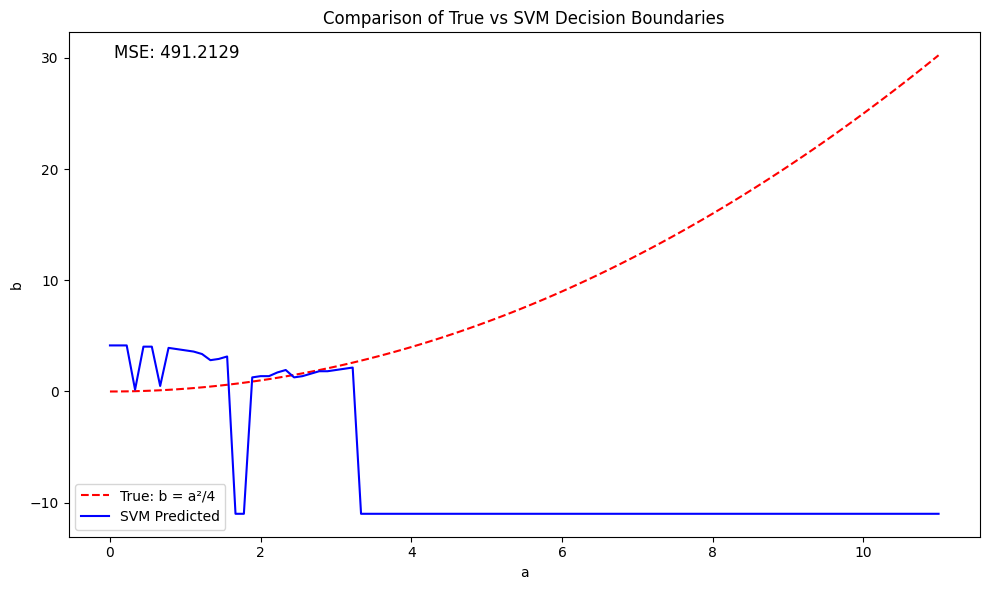

np.float64(491.21294595649704)

In [4]:
# plot 3d decision boundary using svm model
def plot_decision_boundary(svm, data):
    fig = plt.figure(figsize=(12, 10))
    ax = fig.add_subplot(111, projection='3d')
    
    # Define the ranges for visualization
    a_min, a_max = data['a'].min() - 1, data['a'].max() + 1
    b_min, b_max = data['b'].min() - 1, data['b'].max() + 1
    
    # Create a mesh grid for visualization
    a_range = np.linspace(a_min, a_max, 100)
    b_range = np.linspace(b_min, b_max, 100)
    A, B = np.meshgrid(a_range, b_range)
    
    # Calculate SVM decision function values
    xy = np.c_[A.ravel(), B.ravel()]
    Z_svm = svm.decision_function(xy)
    Z_svm = Z_svm.reshape(A.shape)
    
    # Calculate true decision boundary: a² - 4b = 0
    Z_true = A**2 - 4*B
    
    # Plot the SVM decision surface
    svm_surface = ax.plot_surface(A, B, Z_svm, alpha=0.5, cmap='Blues', label='SVM Decision Function')
    
    # Plot the true decision boundary surface
    true_surface = ax.plot_surface(A, B, Z_true, alpha=0.4, cmap='Reds', label='True Boundary: a² - 4b = 0')
    
    # Plot the zero contours (decision boundaries)
    ax.contour(A, B, Z_svm, levels=[0], colors='blue', linestyles='-', linewidths=2)
    ax.contour(A, B, Z_true, levels=[0], colors='red', linestyles='--', linewidths=2)
    
    # Plot the data points
    #scatter = ax.scatter(data['a'], data['b'], data['y'], c=data['r'], cmap='viridis', edgecolor='k', s=50)
    
    # Add labels and title
    ax.set_xlabel('a')
    ax.set_ylabel('b')
    ax.set_zlabel('Decision Function')
    ax.set_title('SVM vs True Decision Boundary (a² - 4b = 0)')
    
    # Add a custom legend
    true_proxy = plt.Rectangle((0, 0), 1, 1, fc="red", alpha=0.4)
    svm_proxy = plt.Rectangle((0, 0), 1, 1, fc="blue", alpha=0.4)
    true_line = plt.Line2D([0], [0], color='red', linestyle='--', linewidth=2)
    svm_line = plt.Line2D([0], [0], color='blue', linewidth=2)
    
    legend1 = ax.legend([true_proxy, true_line, svm_proxy, svm_line], 
                        ['True Function', 'True Boundary', 'SVM Function', 'SVM Boundary'],
                        loc='upper left')
    
    # Add data point legend
    #legend2 = ax.legend(*scatter.legend_elements(), title="Classes", loc='upper right')
    ax.add_artist(legend1)
    
    # Create a 2D visualization to better see the decision boundaries
    fig2, ax2 = plt.subplots(figsize=(10, 8))
    
    # Plot the decision boundaries on the 2D plane
    contour_svm = ax2.contour(A, B, Z_svm, levels=[0], colors='blue', linestyles='-', linewidths=2)
    contour_true = ax2.contour(A, B, Z_true, levels=[0], colors='red', linestyles='--', linewidths=2)
    
    # Plot the data points
    scatter2 = ax2.scatter(data['a'], data['b'], c=data['r'], cmap='viridis', edgecolor='k')
    
    # Add true boundary curve: a² - 4b = 0 => b = a²/4
    a_curve = np.linspace(max(0, a_min), a_max, 100)
    b_curve = a_curve**2 / 4
    ax2.plot(a_curve, b_curve, 'r--', linewidth=2)
    
    # Add labels and title
    ax2.set_xlabel('a')
    ax2.set_ylabel('b')
    ax2.set_title('2D View: SVM vs True Decision Boundary (a² - 4b = 0)')
    
    # Add legend
    ax2.legend([contour_svm.collections[0], contour_true.collections[0], scatter2], 
              ['SVM Boundary', 'True Boundary', 'Data Points'])
    
    # Calculate and display mean squared error between the boundaries
    # Sample points along both boundaries and compute error
    boundary_points = 100
    a_sample = np.linspace(max(0, a_min), a_max, boundary_points)
    b_true = a_sample**2 / 4
    
    # Predict b values from SVM boundary
    # For each a value, find the b value where the SVM decision function = 0
    b_svm = np.zeros_like(a_sample)
    for i, a_val in enumerate(a_sample):
        # Create a range of possible b values
        b_test = np.linspace(b_min, b_max, 200)
        # Evaluate SVM at these points
        test_points = np.column_stack([np.full_like(b_test, a_val), b_test])
        decisions = svm.decision_function(test_points)
        # Find the b value where decision is closest to 0
        closest_idx = np.abs(decisions).argmin()
        b_svm[i] = b_test[closest_idx]
    
    # Calculate MSE between true and SVM boundaries
    mse = np.mean((b_true - b_svm)**2)
    
    # Add MSE text to the 2D plot
    ax2.text(0.05, 0.95, f'MSE between boundaries: {mse:.4f}', 
             transform=ax2.transAxes, fontsize=12, 
             bbox=dict(facecolor='white', alpha=0.8))
    
    # Plot the boundary comparison
    fig3, ax3 = plt.subplots(figsize=(10, 6))
    ax3.plot(a_sample, b_true, 'r--', label='True: b = a²/4')
    ax3.plot(a_sample, b_svm, 'b-', label='SVM Predicted')
    ax3.set_xlabel('a')
    ax3.set_ylabel('b')
    ax3.set_title('Comparison of True vs SVM Decision Boundaries')
    ax3.legend()
    ax3.text(0.05, 0.95, f'MSE: {mse:.4f}', transform=ax3.transAxes, fontsize=12)
    
    plt.tight_layout()
    plt.savefig('svm_vs_true_boundary.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    return mse

plot_decision_boundary(svm, test)

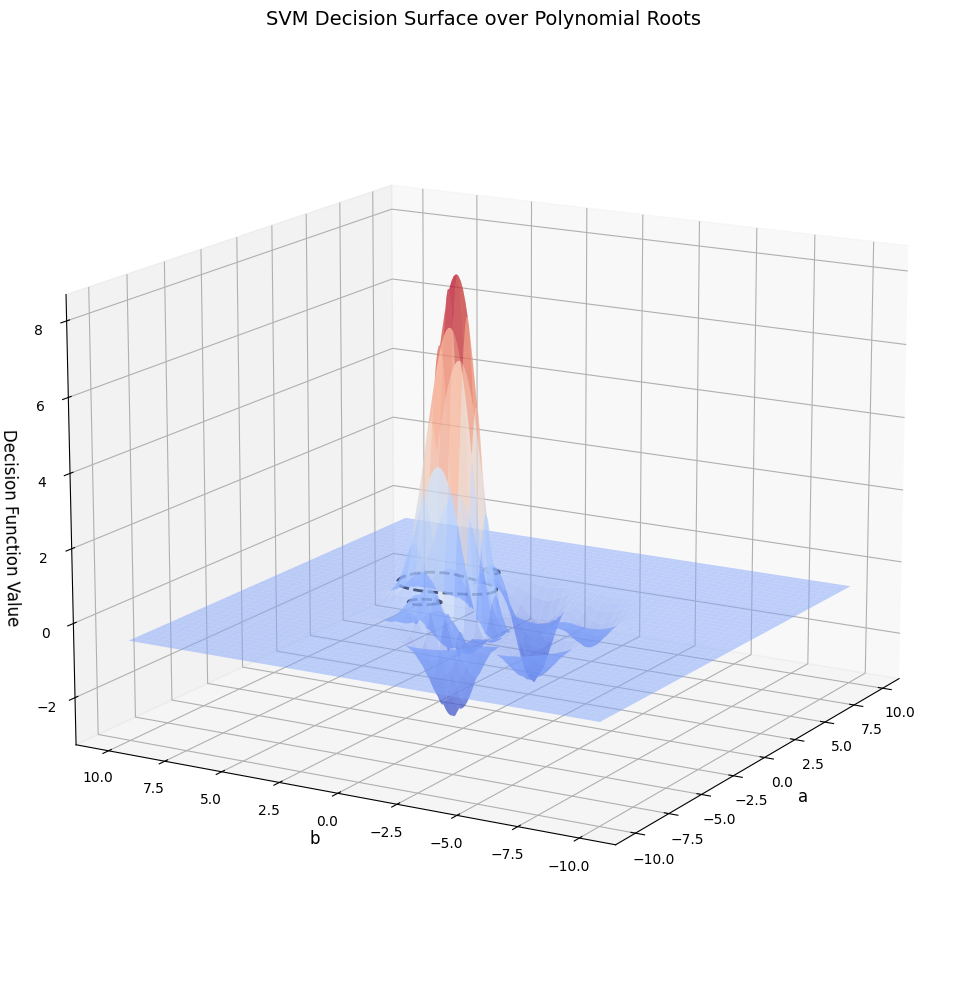

In [5]:
# plot decision surface for X
def plot_decision_surface(svm, data):
    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(111, projection='3d')

    # Create a meshgrid for a and b
    a_range = np.linspace(-10, 10, 200)
    b_range = np.linspace(-10, 10, 200)
    A, B = np.meshgrid(a_range, b_range)

    # Compute decision function over meshgrid
    AB_grid = np.c_[A.ravel(), B.ravel()]
    Z = svm.decision_function(AB_grid).reshape(A.shape)

    # Plot the decision surface
    surf = ax.plot_surface(A, B, Z, alpha=0.5, cmap='coolwarm', edgecolor='none')

    # Plot SVM decision boundary as a contour (Z=0) on the surface
    ax.contour(A, B, Z, levels=[0], colors='black', linestyles='--', linewidths=2)

    # Axis labels and title
    ax.set_xlabel('a', fontsize=12)
    ax.set_ylabel('b', fontsize=12)
    ax.set_zlabel('Decision Function Value', fontsize=12)
    ax.set_title('SVM Decision Surface over Polynomial Roots', fontsize=14)
    ax.view_init(elev=15, azim=210)

    plt.tight_layout()
    plt.show()

plot_decision_surface(svm, test)

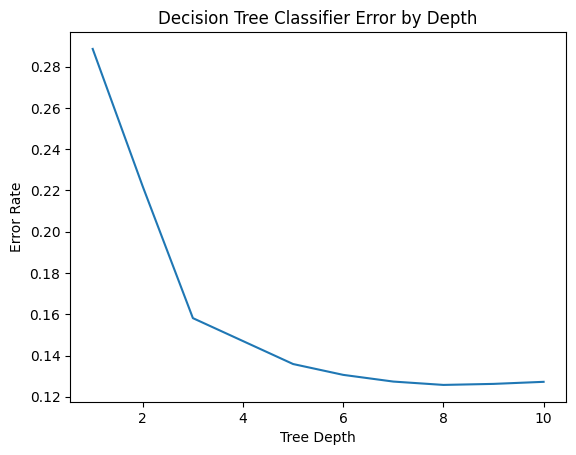

In [55]:
def plot_depths(X, y, X_test, y_test, num_depths=10):
    depths = np.arange(1, num_depths + 1)
    errors = []
    for depth in depths:
        tree = DecisionTreeClassifier(max_depth=depth, random_state=42)
        tree.fit(X, y)
        y_pred = tree.predict(X_test)
        error = np.mean(y_pred != y_test)
        errors.append(error)

    plt.plot(depths, errors)
    plt.xlabel('Tree Depth')
    plt.ylabel('Error Rate')
    plt.title('Decision Tree Classifier Error by Depth')
    plt.show()

plot_depths(X_train_scaled, y_train, X_test_scaled, y_test)

In [ ]:
def plot_min_leaves(X, y, X_test, y_test, depth, num_min_leaves=400):
    min_samples_leaves = np.arange(1, num_min_leaves+1, 5)

    errors = []
    for min_samples_leaf in min_samples_leaves:
        tree = DecisionTreeClassifier(max_depth=depth, min_samples_leaf=min_samples_leaf, random_state=42)
        tree.fit(X, y)
        y_pred = tree.predict(X_test)
        error = np.mean(y_pred != y_test)
        errors.append(error)

    plt.plot(min_samples_leaves, errors)
    plt.xlabel('Min Samples Leaf')
    plt.ylabel('Error Rate')
    plt.title('Decision Tree Classifier Error by Min Samples Leaf')
    plt.show()

plot_min_leaves(X_train_scaled, y_train, X_test_scaled, y_test, depth=5)

In [ ]:
def plot_min_splits(X, y, X_test, y_test, depth, min_samples_leaf=None, num_min_splits=400):
    min_samples_splits = np.arange(2, num_min_splits+1, 5)

    errors = []
    for min_samples_split in min_samples_splits:
        if min_samples_leaf is None:
            tree = DecisionTreeClassifier(max_depth=depth, min_samples_split=min_samples_split, random_state=42)
        else:
            tree = DecisionTreeClassifier(max_depth=depth, min_samples_leaf=min_samples_leaf, min_samples_split=min_samples_split, random_state=42)
        tree.fit(X, y)
        y_pred = tree.predict(X_test)
        error = np.mean(y_pred != y_test)
        errors.append(error)

    plt.plot(min_samples_splits, errors)
    plt.xlabel('Min Samples Split')
    plt.ylabel('Error Rate')
    plt.title('Decision Tree Classifier Error by Min Samples Split')
    plt.show()

plot_min_splits(X_train_scaled, y_train, X_test_scaled, y_test, depth=5, min_samples_leaf=100)

Decision Tree Test set classification report:
              precision    recall  f1-score   support

           0       0.85      0.97      0.91      5376
           1       0.91      0.65      0.76      2624

    accuracy                           0.86      8000
   macro avg       0.88      0.81      0.83      8000
weighted avg       0.87      0.86      0.86      8000



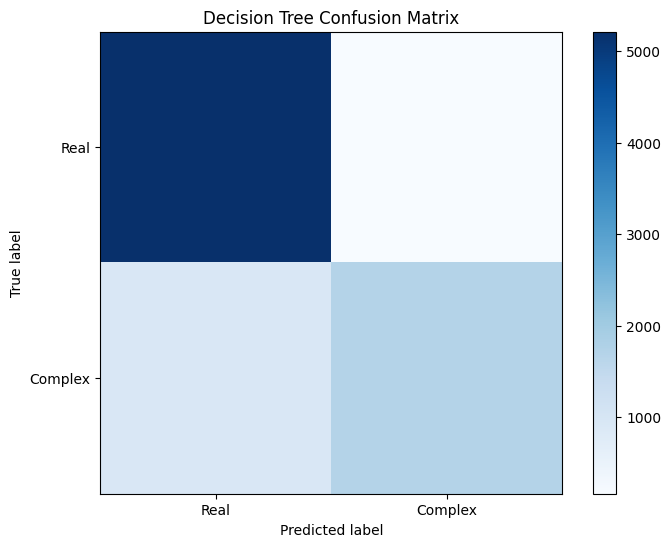

In [6]:
dt = DecisionTreeClassifier(max_depth=5, min_samples_leaf=100, min_samples_split=300, random_state=42)
dt.fit(X_train_scaled, y_train)
y_pred_dt = dt.predict(X_test_scaled)
print("Decision Tree Test set classification report:")
print(classification_report(y_test, y_pred_dt))
cm_dt = confusion_matrix(y_test, y_pred_dt)
plt.figure(figsize=(8, 6))
plt.imshow(cm_dt, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Decision Tree Confusion Matrix')
plt.colorbar()
plt.xticks(np.arange(2), ['Real', 'Complex'])
plt.yticks(np.arange(2), ['Real', 'Complex'])
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.savefig('decision_tree_confusion_matrix.png')
plt.show()

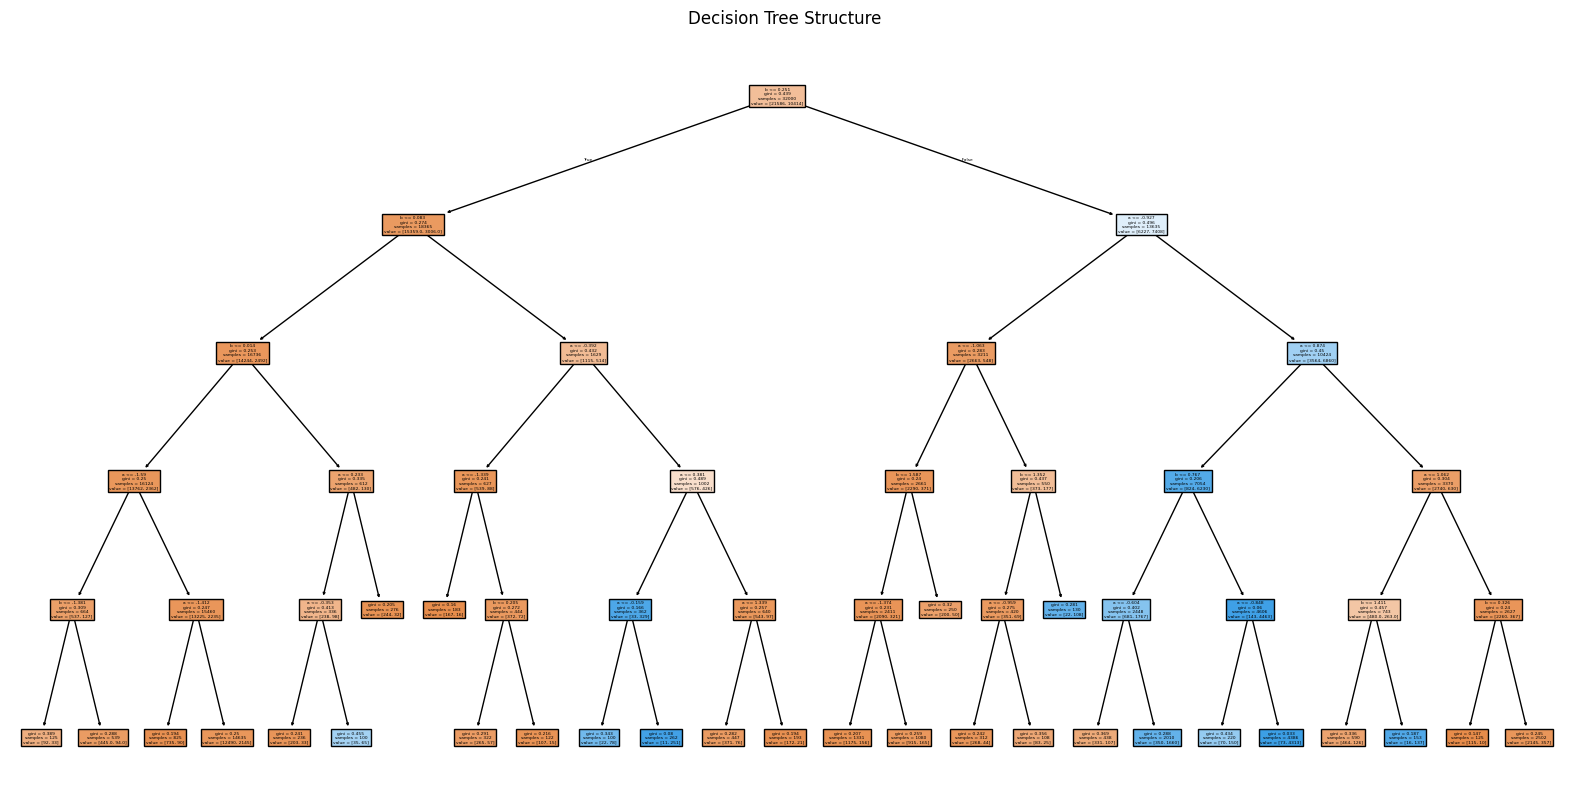

In [7]:
def plot_decision_tree(tree, feature_names, fig_name='decision_tree_structure.png'):
    plt.figure(figsize=(20, 10))
    plot_tree(tree, feature_names=feature_names, filled=True)
    plt.title('Decision Tree Structure')
    plt.savefig(fig_name)
    plt.show()
    
plot_decision_tree(dt, feature_names=['a', 'b'])

In [9]:
df['a^2'] = df['a']**2
df['a*b'] = df['a'] * df['b']
df['b^2'] = df['b']**2
train, test = train_test_split(df, test_size=0.2, random_state=42)
X_train = train[['a', 'b', 'a^2', 'a*b', 'b^2']]
y_train = train['r']
X_test = test[['a', 'b', 'a^2', 'a*b', 'b^2']]
y_test = test['r']
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [ ]:
plot_depths(X_train_scaled, y_train, X_test_scaled, y_test)

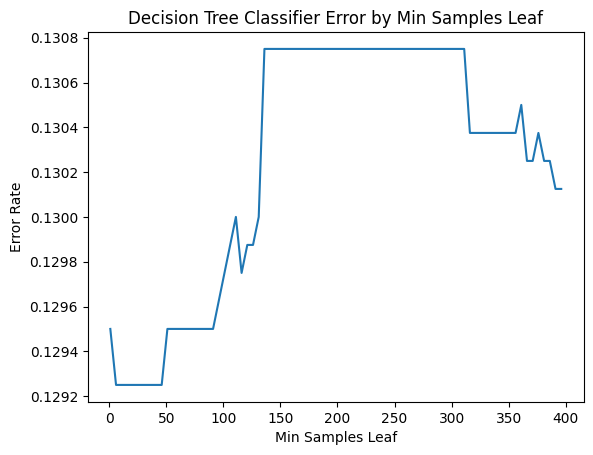

In [61]:
plot_min_leaves(X_train_scaled, y_train, X_test_scaled, y_test, depth=4)

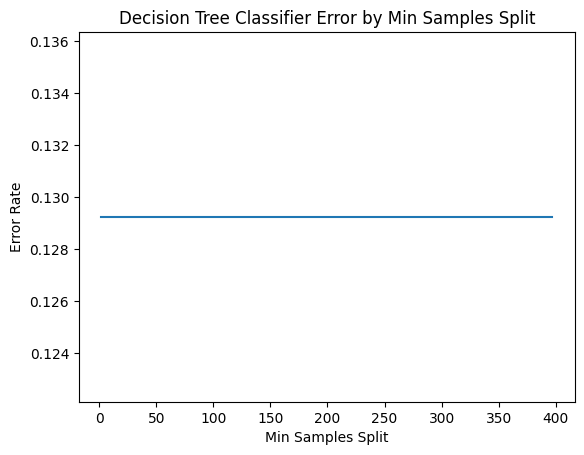

In [63]:
plot_min_splits(X_train_scaled, y_train, X_test_scaled, y_test, depth=4, min_samples_leaf=25)

Decision Tree Test set classification report:
              precision    recall  f1-score   support

           0       0.85      0.98      0.91      5376
           1       0.95      0.64      0.76      2624

    accuracy                           0.87      8000
   macro avg       0.90      0.81      0.84      8000
weighted avg       0.88      0.87      0.86      8000



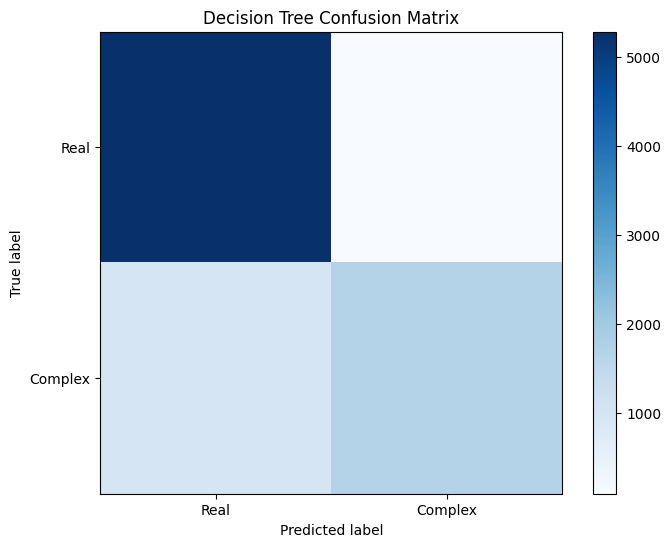

In [10]:
dt = DecisionTreeClassifier(max_depth=4, min_samples_leaf=25, random_state=42)
dt.fit(X_train_scaled, y_train)
y_pred_dt = dt.predict(X_test_scaled)
print("Decision Tree Test set classification report:")
print(classification_report(y_test, y_pred_dt))
cm_dt = confusion_matrix(y_test, y_pred_dt)
plt.figure(figsize=(8, 6))
plt.imshow(cm_dt, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Decision Tree Confusion Matrix')
plt.colorbar()
plt.xticks(np.arange(2), ['Real', 'Complex'])
plt.yticks(np.arange(2), ['Real', 'Complex'])
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.savefig('decision_tree_confusion_matrix.png')
plt.show()

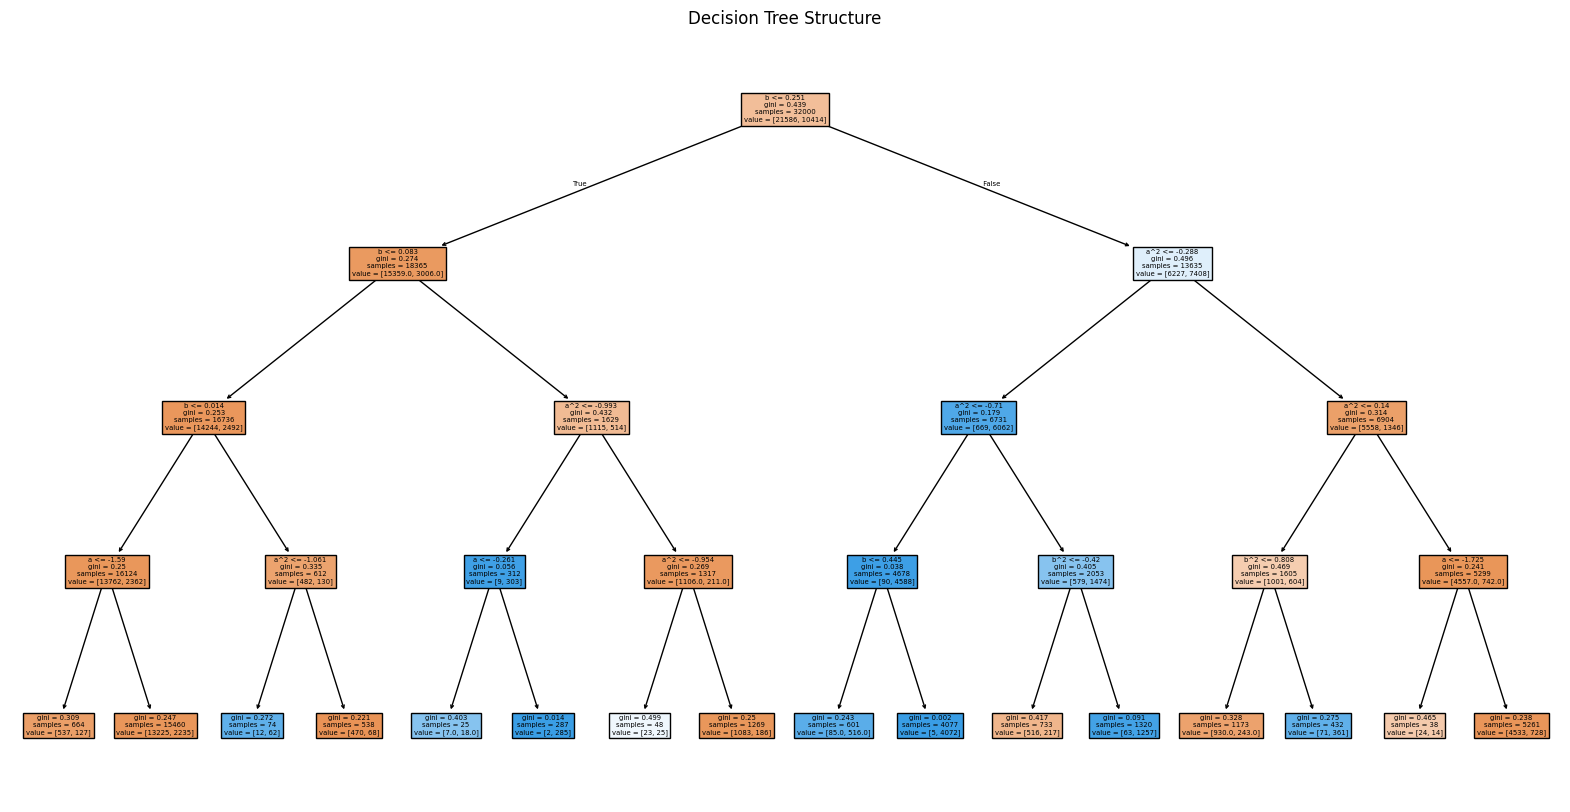

In [ ]:
plot_decision_tree(dt, feature_names=['a', 'b', 'a^2', 'a*b', 'b^2'], fig_name='decision_tree_structure_more_terms.png')

/tmp/ipykernel_9342/1899170358.py:69: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed in 3.10.
  ax2.legend([contour_svm.collections[0], contour_true.collections[0], scatter2],


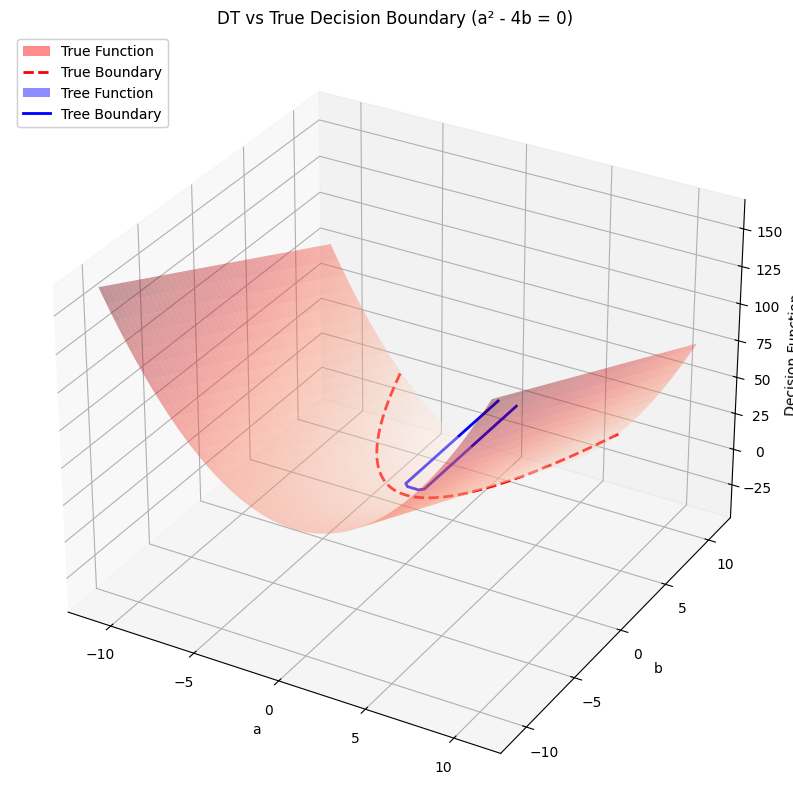

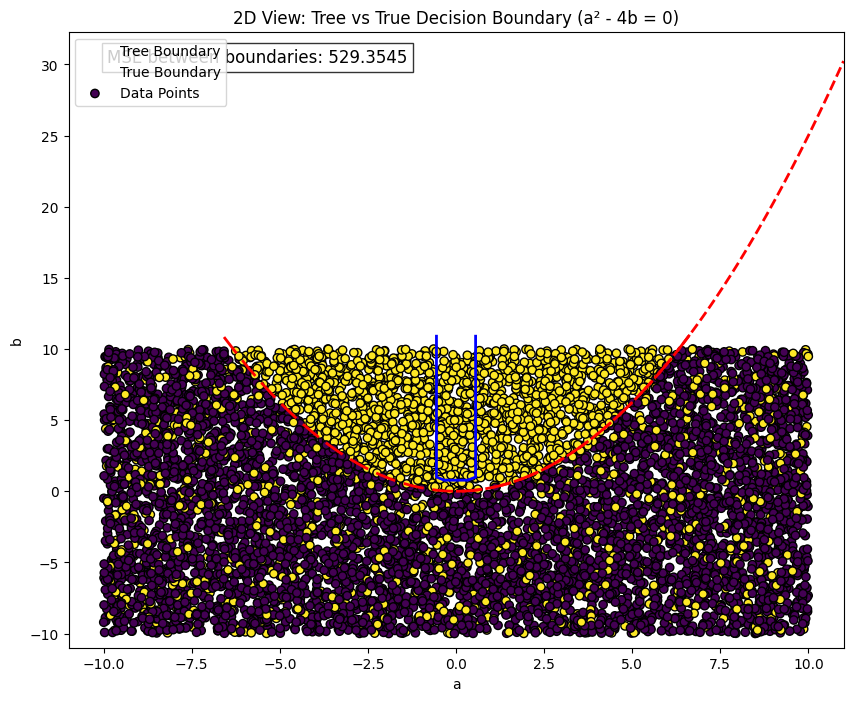

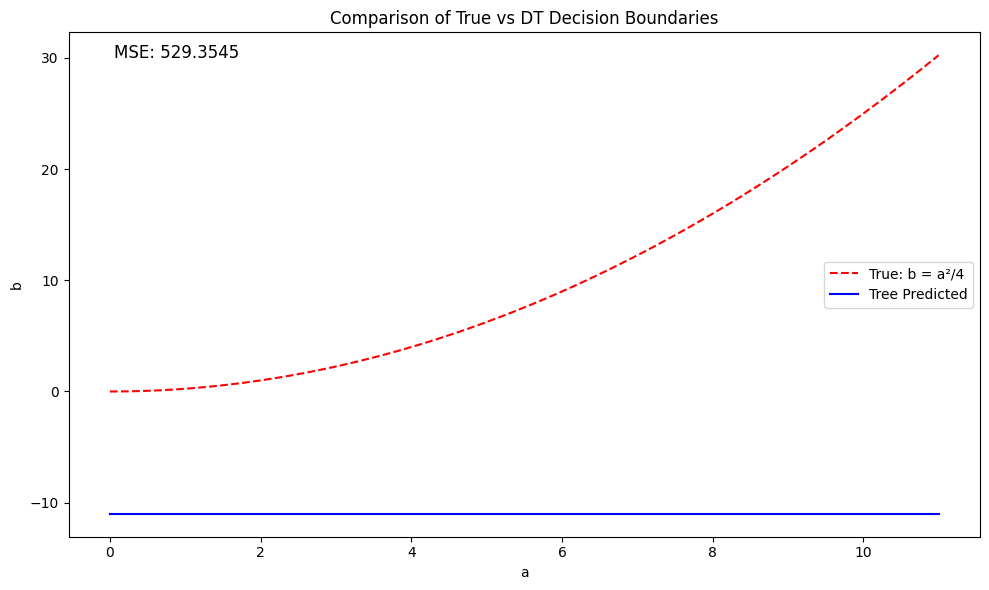

np.float64(529.3544564466165)

In [15]:
def plot_decision_boundary(tree, data):
    fig = plt.figure(figsize=(12, 10))
    ax = fig.add_subplot(111, projection='3d')
    
    # Define the ranges for visualization
    a_min, a_max = data['a'].min() - 1, data['a'].max() + 1
    b_min, b_max = data['b'].min() - 1, data['b'].max() + 1
    
    # Create a mesh grid for visualization
    a_range = np.linspace(a_min, a_max, 100)
    b_range = np.linspace(b_min, b_max, 100)
    A, B = np.meshgrid(a_range, b_range)
    A2 = A**2
    AB = A * B
    B2 = B**2

    Z_tree = tree.predict(np.c_[A.ravel(), B.ravel(), A2.ravel(), AB.ravel(), B2.ravel()])
    Z_tree = Z_tree.reshape(A.shape)
    Z_true = A**2 - 4*B
    
    # Plot the true decision boundary surface
    true_surface = ax.plot_surface(A, B, Z_true, alpha=0.4, cmap='Reds', label='True Boundary: a² - 4b = 0')
    
    # Plot the zero contours (decision boundaries)
    ax.contour(A, B, Z_tree, levels=[0], colors='blue', linestyles='-', linewidths=2)
    ax.contour(A, B, Z_true, levels=[0], colors='red', linestyles='--', linewidths=2)
    
    # Add labels and title
    ax.set_xlabel('a')
    ax.set_ylabel('b')
    ax.set_zlabel('Decision Function')
    ax.set_title('DT vs True Decision Boundary (a² - 4b = 0)')
    
    # Add a custom legend
    true_proxy = plt.Rectangle((0, 0), 1, 1, fc="red", alpha=0.4)
    tree_proxy = plt.Rectangle((0, 0), 1, 1, fc="blue", alpha=0.4)
    true_line = plt.Line2D([0], [0], color='red', linestyle='--', linewidth=2)
    tree_line = plt.Line2D([0], [0], color='blue', linewidth=2)
    
    legend1 = ax.legend([true_proxy, true_line, tree_proxy, tree_line], 
                        ['True Function', 'True Boundary', 'Tree Function', 'Tree Boundary'],
                        loc='upper left')
    
    # Add data point legend
    #legend2 = ax.legend(*scatter.legend_elements(), title="Classes", loc='upper right')
    ax.add_artist(legend1)
    
    # Create a 2D visualization to better see the decision boundaries
    fig2, ax2 = plt.subplots(figsize=(10, 8))
    
    # Plot the decision boundaries on the 2D plane
    contour_svm = ax2.contour(A, B, Z_tree, levels=[0], colors='blue', linestyles='-', linewidths=2)
    contour_true = ax2.contour(A, B, Z_true, levels=[0], colors='red', linestyles='--', linewidths=2)
    
    # Plot the data points
    scatter2 = ax2.scatter(data['a'], data['b'], c=data['r'], cmap='viridis', edgecolor='k')
    
    # Add true boundary curve: a² - 4b = 0 => b = a²/4
    a_curve = np.linspace(max(0, a_min), a_max, 100)
    b_curve = a_curve**2 / 4
    ax2.plot(a_curve, b_curve, 'r--', linewidth=2)
    
    # Add labels and title
    ax2.set_xlabel('a')
    ax2.set_ylabel('b')
    ax2.set_title('2D View: Tree vs True Decision Boundary (a² - 4b = 0)')
    
    # Add legend
    ax2.legend([contour_svm.collections[0], contour_true.collections[0], scatter2], 
              ['Tree Boundary', 'True Boundary', 'Data Points'])
    
    # Calculate and display mean squared error between the boundaries
    # Sample points along both boundaries and compute error
    boundary_points = 100
    a_sample_values = np.linspace(max(0, a_min), a_max, boundary_points)
    b_true = a_sample_values**2 / 4
    
    # Predict b values from SVM boundary
    # For each a value, find the b value where the SVM decision function = 0
    b_tree = np.zeros_like(a_sample_values)
    for i, a_val in enumerate(a_sample_values):
        # Create a range of possible b values
        b_test = np.linspace(b_min, b_max, 200)
        # Create corresponding features for each test point
        a_vals = np.full_like(b_test, a_val)
        a2_vals = a_vals**2
        ab_vals = a_vals * b_test
        b2_vals = b_test**2
        test_points = np.column_stack([a_vals, b_test, a2_vals, ab_vals, b2_vals])
        # Predict using the decision tree
        decisions = tree.predict(test_points)
        # Find the b value where decision is closest to 0
        closest_idx = np.abs(decisions).argmin()
        b_tree[i] = b_test[closest_idx]
    
    # Calculate MSE between true and SVM boundaries
    mse = np.mean((b_true - b_tree)**2)
    
    # Add MSE text to the 2D plot
    ax2.text(0.05, 0.95, f'MSE between boundaries: {mse:.4f}', 
             transform=ax2.transAxes, fontsize=12, 
             bbox=dict(facecolor='white', alpha=0.8))
    
    # Plot the boundary comparison
    fig3, ax3 = plt.subplots(figsize=(10, 6))
    ax3.plot(a_sample_values, b_true, 'r--', label='True: b = a²/4')
    ax3.plot(a_sample_values, b_tree, 'b-', label='Tree Predicted')
    ax3.set_xlabel('a')
    ax3.set_ylabel('b')
    ax3.set_title('Comparison of True vs DT Decision Boundaries')
    ax3.legend()
    ax3.text(0.05, 0.95, f'MSE: {mse:.4f}', transform=ax3.transAxes, fontsize=12)
    
    plt.tight_layout()
    plt.savefig('tree_vs_true_boundary.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    return mse

plot_decision_boundary(dt, test)

In [20]:
from sklearn.neural_network import MLPClassifier

mlp = MLPClassifier(hidden_layer_sizes=(100,), max_iter=1000, random_state=42)
mlp.fit(X_train_scaled, y_train)
y_pred_mlp = mlp.predict(X_test_scaled)
print("MLP Test set classification report:")
print(classification_report(y_test, y_pred_mlp))

MLP Test set classification report:
              precision    recall  f1-score   support

           0       0.85      0.99      0.91      5376
           1       0.96      0.65      0.78      2624

    accuracy                           0.88      8000
   macro avg       0.90      0.82      0.84      8000
weighted avg       0.89      0.88      0.87      8000



ValueError: X has 5 features, but MLPClassifier is expecting 2 features as input.

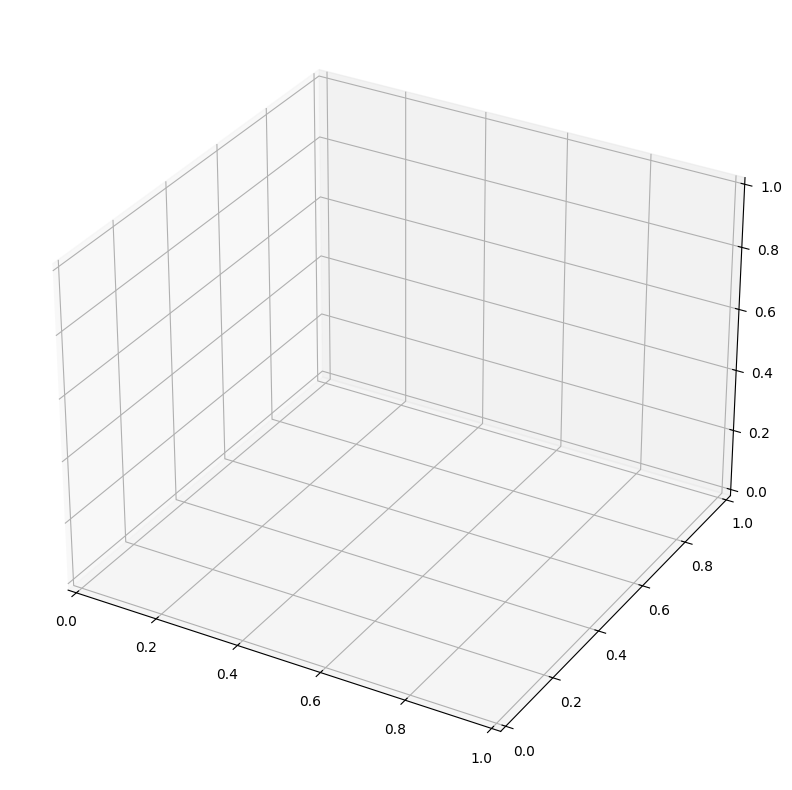

In [ ]:
def plot_mlp_decision_boundary(mlp, data):
    fig = plt.figure(figsize=(12, 10))
    ax = fig.add_subplot(111, projection='3d')
    
    # Define the ranges for visualization
    a_min, a_max = data['a'].min() - 1, data['a'].max() + 1
    b_min, b_max = data['b'].min() - 1, data['b'].max() + 1
    
    # Create a mesh grid for visualization
    a_range = np.linspace(a_min, a_max, 100)
    b_range = np.linspace(b_min, b_max, 100)
    A, B = np.meshgrid(a_range, b_range)
    A2 = A**2
    AB = A * B
    B2 = B**2

    Z_mlp = mlp.predict(np.c_[A.ravel(), B.ravel(), A2.ravel(), AB.ravel(), B2.ravel()])
    Z_mlp = Z_mlp.reshape(A.shape)
    
    # Plot the zero contours (decision boundaries)
    ax.contour(A, B, Z_mlp, levels=[0], colors='blue', linestyles='-', linewidths=2)
    
    # Add labels and title
    ax.set_xlabel('a')
    ax.set_ylabel('b')
    ax.set_zlabel('Decision Function')
    ax.set_title('MLP Decision Boundary (a² - 4b = 0)')
    
    # Add a custom legend
    mlp_proxy = plt.Rectangle((0, 0), 1, 1, fc="blue", alpha=0.4)
    
    legend1 = ax.legend([mlp_proxy], 
                        ['MLP Function'],
                        loc='upper left')
    
    # Create a 2D visualization to better see the decision boundaries
    fig2, ax2 = plt.subplots(figsize=(10, 8))
    
    # Plot the decision boundaries on the 2D plane
    contour_mlp = ax2.contour(A, B, Z_mlp, levels=[0], colors='blue', linestyles='-', linewidths=2)
    
    # Plot the data points
    scatter2 = ax2.scatter(data['a'], data['b'], c=data['r'], cmap='viridis', edgecolor='k')
    # Add true boundary curve: a² - 4b = 0 => b = a²/4
    a_curve = np.linspace(max(0, a_min), a_max, 100)
    b_curve = a_curve**2 / 4
    ax2.plot(a_curve, b_curve, 'r--', linewidth=2)
    # Add labels and title
    ax2.set_xlabel('a')
    ax2.set_ylabel('b')
    ax2.set_title('2D View: MLP Decision Boundary (a² - 4b = 0)')
    # Add legend
    ax2.legend([contour_mlp.collections[0], scatter2], 
              ['MLP Boundary', 'Data Points'])
    # Calculate and display mean squared error between the boundaries
    # Sample points along both boundaries and compute error
    boundary_points = 100
    a_sample_values = np.linspace(max(0, a_min), a_max, boundary_points)
    b_true = a_sample_values**2 / 4
    # Predict b values from MLP boundary
    # For each a value, find the b value where the MLP decision function = 0
    b_mlp = np.zeros_like(a_sample_values)
    for i, a_val in enumerate(a_sample_values):
        # Create a range of possible b values
        b_test = np.linspace(b_min, b_max, 200)
        # Create corresponding features for each test point
        a_vals = np.full_like(b_test, a_val)
        a2_vals = a_vals**2
        ab_vals = a_vals * b_test
        b2_vals = b_test**2
        test_points = np.column_stack([a_vals, b_test, a2_vals, ab_vals, b2_vals])
        # Predict using the MLP
        decisions = mlp.predict(test_points)
        # Find the b value where decision is closest to 0
        closest_idx = np.abs(decisions).argmin()
        b_mlp[i] = b_test[closest_idx]
    # Calculate MSE between true and MLP boundaries
    mse = np.mean((b_true - b_mlp)**2)
    # Add MSE text to the 2D plot
    ax2.text(0.05, 0.95, f'MSE between boundaries: {mse:.4f}', 
             transform=ax2.transAxes, fontsize=12, 
             bbox=dict(facecolor='white', alpha=0.8))
    # Plot the boundary comparison
    fig3, ax3 = plt.subplots(figsize=(10, 6))
    ax3.plot(a_sample_values, b_true, 'r--', label='True: b = a²/4')
    ax3.plot(a_sample_values, b_mlp, 'b-', label='MLP Predicted')
    ax3.set_xlabel('a')
    ax3.set_ylabel('b')
    ax3.set_title('Comparison of True vs MLP Decision Boundaries')
    ax3.legend()
    ax3.text(0.05, 0.95, f'MSE: {mse:.4f}', transform=ax3.transAxes, fontsize=12)
    plt.tight_layout()
    plt.savefig('mlp_vs_true_boundary.png', dpi=300, bbox_inches='tight')
    plt.show()

plot_mlp_decision_boundary(mlp, test)